# 5-1. 분류 모형의 변수 선택
> 데이터 파일 : https://archive.ics.edu/ml/machine-learning-database/wine-quality/winequality-red.csv

In [2]:
## 1. 데이터 불러오기
import pandas as pd
redwine = pd.read_csv('winequality-red.csv', delimiter=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


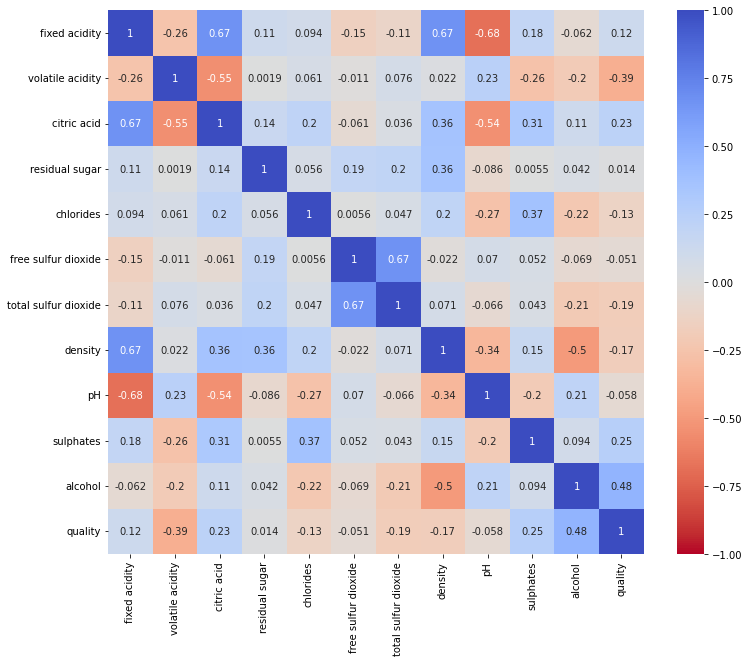

In [3]:
## 훈련용, 검증용 데이터 분리
X = redwine.iloc[:, :-1]
y = redwine.iloc[:, -1]
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

## 2. 상관관계 확인하기
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,10))
sns.heatmap(redwine.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
plt.show()

#### 3. 분류모형의 Feature Importance
분류 모형의 `feature_importances_` 변수는 종속변수에 영향을 주는 독립변수들의 기여도 저장
`RandomForestClassifier`를 이용한 분류 모형 : 랜덤 포레스트는 여러 의사 결정 나무 분류기에 데이터 집합의 다양한 하위 샘플에 적합하고 평균을 사용하여 예측 정확도를 개선하고 과적합을 제어하는 추정기
- 중요 매개변수 : `n_estimators`
- randon_state : 매 실행 시 결과 변하지 않게 하기 위해 발생 시드 저장


In [4]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [5]:
rf_model.feature_importances_ # 각 독립변수가 종속변수에 영향을 주는 정도 저장
import numpy as np
np.sum(rf_model.feature_importances_) # feature_importances_의 총 합 1

1.0

In [6]:
## 변수별로 중요도 갖는 데이터 프레임 만들기
features = pd.DataFrame(data=np.c_[X.columns.values, rf_model.feature_importances_], columns=["feature", "importance"])
## 만들어진 데이터프레임을 중요도 내림차순으로 정렬, 정렬된 데이터의 인덱스 초기화 하면 순위 확인 쉬워짐
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features

,feature,importance
0,alcohol,0.147122
1,sulphates,0.117706
2,total sulfur dioxide,0.102782
3,volatile acidity,0.10245
4,density,0.092932
5,chlorides,0.082399
6,fixed acidity,0.08191
7,residual sugar,0.07532
8,citric acid,0.07215
9,pH,0.065598


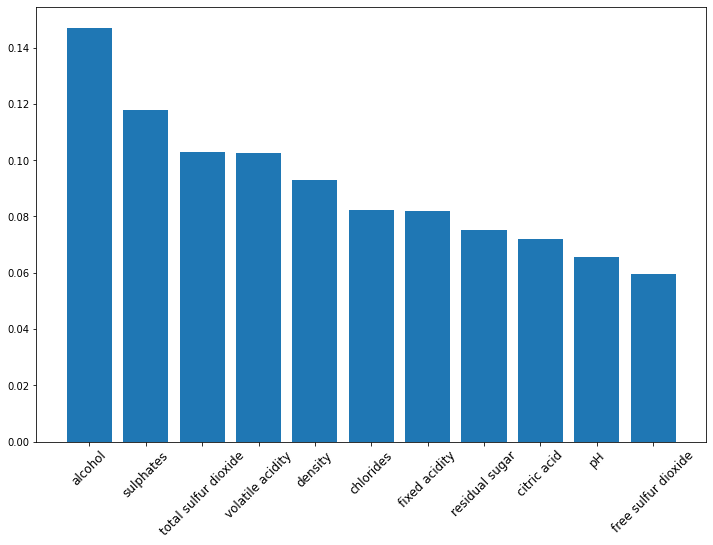

In [7]:
## 변수별 중요도 갖는 데이터프레임 막대그래프로 표현
plt.figure(figsize=(12, 8))
plt.bar(features.feature, features.importance)
plt.xticks(features.feature, fontsize=12, rotation=45)
plt.show()

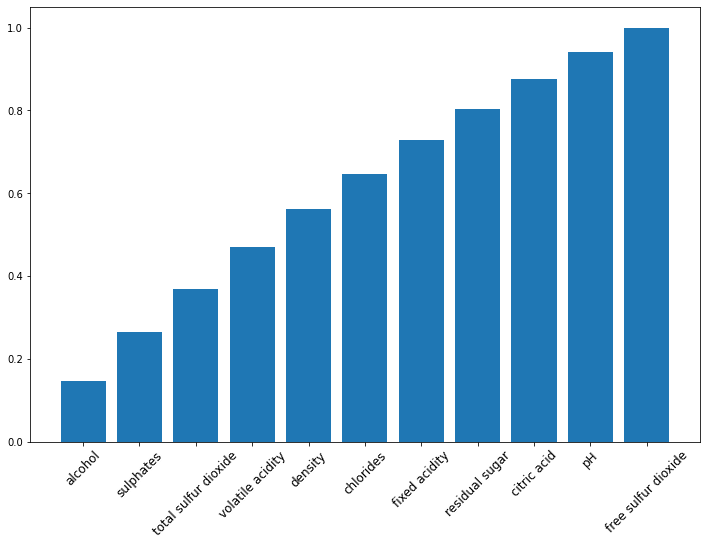

In [8]:
## 특정 변수들의 누적 합 그래프로 표현
y_stack = np.cumsum(features.importance, axis=0)
plt.figure(figsize=(12, 8))
plt.bar(features.feature, y_stack)
plt.xticks(features.feature, fontsize=12, rotation=45)
plt.show()
## 누적합이 선형일 경우, 변수의 수를 줄이지 않는 것이 바람직함. => 모든 변수를 포함해야 모형 정확도 높음

### 4. RFE(Recursive Feature Elimination) 방식
중요도에 따라 가장 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택하고자 하는 변수의 개수만큼 중요도가 높은 변수를 찾음.
첫 번째 인수인 `estimator`는 예측을 위한 모형 객체를 의미, 매개변수 `n_feature_to_select`는 선택할 변수의 수를 지정

In [9]:
## 중요한 변수 4개 찾기
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

rfe_model = RFE(RandomForestClassifier(n_estimators=10, random_state=10), n_features_to_select=5)
rfe_model.fit(train_X, train_y)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=5)

In [10]:
## 어떠한 변수가 선택되었는지 반환
rfe_model.get_support()

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [11]:
import numpy as np
import pandas as pd
features_rfe = pd.DataFrame(data=np.c_[X.columns.values, rfe_model.get_support()], columns=["feature", "selected"])
features.merge(features_rfe)

,feature,importance,selected
0,alcohol,0.147122,True
1,sulphates,0.117706,True
2,total sulfur dioxide,0.102782,True
3,volatile acidity,0.10245,True
4,density,0.092932,True
5,chlorides,0.082399,False
6,fixed acidity,0.08191,False
7,residual sugar,0.07532,False
8,citric acid,0.07215,False
9,pH,0.065598,False


In [12]:
## 모델 저장
import pickle
with open("rf.model", "wb") as f:
    pickle.dump(rf_model, f)

# ## 모델 불러오기
# import pickle
# with open("rf.model", "rb") as f:
#     rf_model = pickle.load(f)

# ## 데이터 예측
# rf_model.predict(test_X[:10])   # test_y[:10].values 와 비교해보기

In [13]:
## 모델 불러오기
import pickle
with open("rf.model", "rb") as f:
    rf_model = pickle.load(f)

## 데이터 예측
rf_model.predict(test_X[:10])   # test_y[:10].values 와 비교해보기

array([6, 5, 6, 5, 5, 6, 5, 5, 5, 5], dtype=int64)

In [14]:
test_y[:10].values

array([6, 6, 6, 6, 3, 6, 5, 4, 6, 5], dtype=int64)